In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import gudhi as gd
from sklearn.neighbors import KernelDensity, KDTree
import random
import multiprocessing
from scipy.cluster import hierarchy

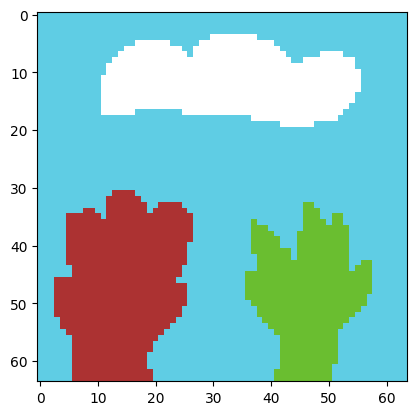

In [2]:
img_rgb = plt.imread('data/WorkOfArt.png', 'PNG')
plt.imshow(img_rgb)

In [3]:
img_rgb.shape

(64, 64, 4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


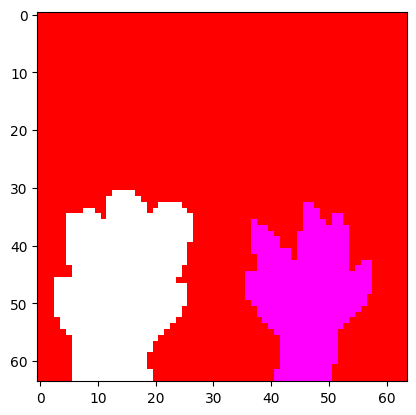

In [4]:
img_luv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Luv)
plt.imshow(img_luv)

In [5]:
img_luv.shape

(64, 64, 3)

In [6]:
l, u, v = [], [], []
for i in range(img_luv.shape[0]):
    for j in range(img_luv.shape[1]):
        l.append(img_luv[i, j, 0])
        u.append(img_luv[i, j, 1])
        v.append(img_luv[i, j, 2])

In [7]:
x = np.vstack((l, u, v)).T
x.shape

(4096, 3)

In [8]:
print(x)

[[ 77.09687  -44.8725   -29.339354]
 [ 77.09687  -44.8725   -29.339354]
 [ 77.09687  -44.8725   -29.339354]
 ...
 [ 77.09687  -44.8725   -29.339354]
 [ 77.09687  -44.8725   -29.339354]
 [ 77.09687  -44.8725   -29.339354]]


In [9]:
def parallel_score_samples(kde, samples, thread_count=int(0.875 * multiprocessing.cpu_count())):
    with multiprocessing.Pool(thread_count) as p:
        return np.concatenate(p.map(kde.score_samples, np.array_split(samples, thread_count)))

In [10]:
kde = KernelDensity(bandwidth=2.0, atol=0.0005, rtol=0.01).fit(x) 
log_prob = parallel_score_samples(kde, x)

In [11]:
prob = np.exp(log_prob)

In [12]:
sparse = 3
sparse_matrix = np.asarray([[(j%sparse==0)&(i%sparse==0) for i in range(img_luv.shape[1])] for j in range(img_luv.shape[0])])
sparse_array = sparse_matrix.flatten()

In [13]:
x_train = x[sparse_array]
x_train = np.asarray([list(x_train[random.randrange(x_train.shape[0])]) for i in np.arange(20000)])
x_train.shape

(20000, 3)

In [14]:
linked = hierarchy.linkage(x_train, 'single')

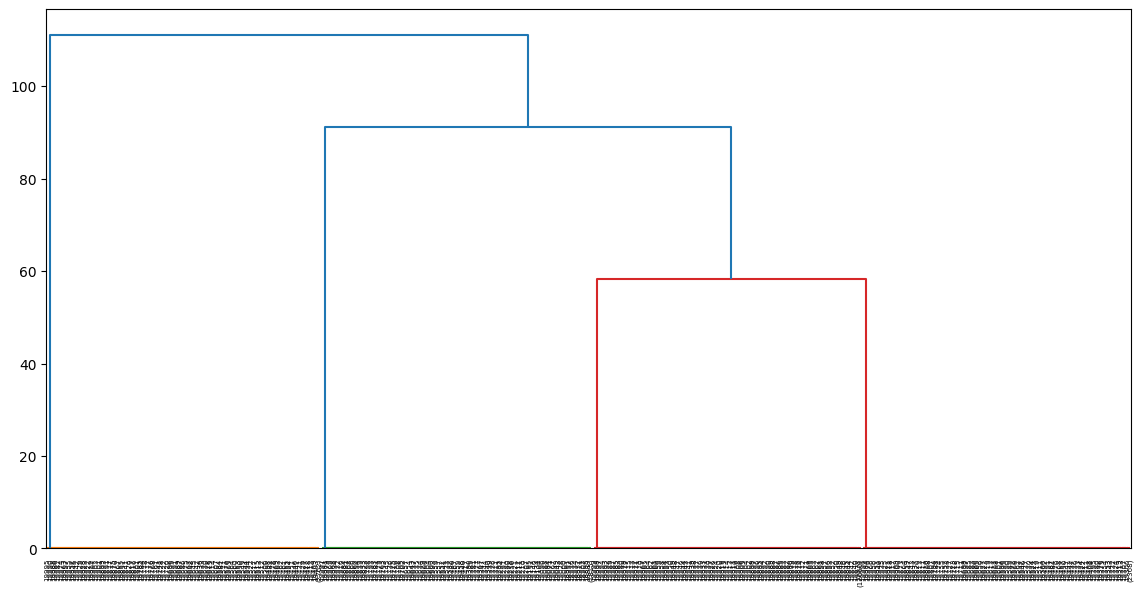

In [15]:
plt.figure(figsize=(14, 7))
hierarchy.dendrogram(linked, p=100, truncate_mode='level')
plt.show()

In [16]:
kdt = KDTree(x, metric='euclidean')

In [17]:
sigmas = np.linspace(0, 5, 10)
avg_neighbor_count = [np.mean([kdt.query_radius([x_train[i]], sigmas[j], return_distance=False)[0].shape[0] for i in range(x_train.shape[0])]) 
           for j in range(len(sigmas))]

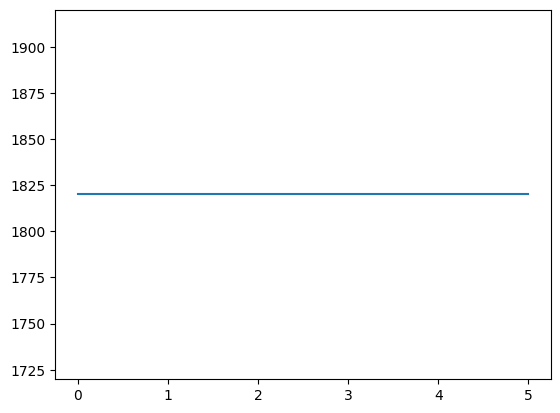

In [18]:
plt.plot(sigmas, avg_neighbor_count)

In [19]:
sigma = 2

In [20]:
class UnionFind:
    def __init__(self):
        self.num_to_objects = {}
        self.objects_to_num = {}
        self.parent = {}
    
    def insert(self, object):
        obj_num = len(self.objects_to_num)
        self.objects_to_num[object] = obj_num
        self.num_to_objects[obj_num] = object
        self.parent[obj_num] = obj_num
    
    def find(self, object): 
        obj_num = self.objects_to_num[object]
        if self.parent[obj_num] == obj_num:
            return self.num_to_objects[obj_num]

        else:
            return self.find(self.parent[obj_num])
        
    def union(self, object1, object2): 
        first = self.find(object1)
        second = self.find(object2)
        if first != second:
            first_num = self.objects_to_num[first]
            second_num = self.objects_to_num[second]
            self.parent[second_num] = first_num

In [21]:
U = UnionFind()
U.insert(1)
U.insert(12)
U.union(1, 12)
U.parent

{0: 0, 1: 0}

In [22]:
def fuse(prob, U, i, S, tau):
    pass

In [23]:
def cluster(prob, distance_matrix, sigma, tau):
    sorted_indices = np.argsort(prob)
    U = UnionFind()
    n = len(prob)
    births = {}
    deaths = {}
    
    for i in reversed(range(n)):
        id = sorted_indices[i]
        neighbors = kdt.query_radius([x[id]], sigma, return_distance=False)[0]
        S = [elem for elem in neighbors if (elem in sorted_indices[(i+1):])]
        if not S:
            U.insert(id)
            births[id] = -prob[id]
        else:
            g = S[np.asarray([prob[j] for j in S]).argmax()]
            union(g, id)
            U = fuse(prob, U, id, S, tau)